In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from torch.optim import Adam
from sklearn.utils import resample
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
class RedMulticapa(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3, hidden4, hidden5, output_size):
        super(RedMulticapa, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1)
        self.hidden2 = nn.Linear(hidden1, hidden2)
        self.hidden3 = nn.Linear(hidden2, hidden3)
        self.hidden4 = nn.Linear(hidden3, hidden4)
        self.hidden5 = nn.Linear(hidden4, hidden5)
        self.output = nn.Linear(hidden5, output_size)
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()
        self.historial = []

    def feed_forward(self, X):
        x = self.hidden1(X)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.sigmoid(x)
        x = self.hidden3(x)
        x = self.sigmoid(x)
        x = self.hidden4(x)
        x = self.sigmoid(x)
        x = self.hidden5(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

    def back_propagate(self, X, Y):
        outputs = self.feed_forward(X)
        error = self.loss(outputs, Y)
        self.zero_grad()
        error.backward()

    def track_progress(self, error):
        self.historial.append(error.item())

    def train(self, train_X, train_Y, optimizer, ciclos=10000):
        for i in range(ciclos):
            self.back_propagate(train_X, train_Y)
            optimizer.step()
            outputs = self.feed_forward(train_X)
            error = self.loss(outputs, train_Y)
            self.track_progress(error)

    def confusion(self, test_X, test_Y):
        with torch.no_grad():
            predictions = self.feed_forward(test_X)
            for i in range(len(predictions)):
                if predictions[i] <= 0.5:
                    predictions[i] = 0
                else:
                    predictions[i] = 1

        num_classes = 2
        confusion_matrix_result = [[0, 0], [0, 0]]

        for i in range(len(test_Y)):
            true_label = test_Y[i]
            pred = predictions[i]

            if true_label == pred:
                if pred == 1:
                    confusion_matrix_result[0][0] += 1
                else:
                    confusion_matrix_result[1][1] += 1
            else:
                if true_label == 1:
                    confusion_matrix_result[1][0] += 1
                else:
                    confusion_matrix_result[0][1] += 1

        return confusion_matrix_result

In [3]:
def OneHot(df):

    encoder = OneHotEncoder()

    # 'sex' a one-hot
    sex_columna = df[['sex']]
    sex_one_hot = encoder.fit_transform(sex_columna)
    sex_one_hot_df = pd.DataFrame(sex_one_hot.toarray(), columns=encoder.get_feature_names_out(['sex']))
    df_one_hot = pd.concat([df, sex_one_hot_df], axis=1)
    df_one_hot.drop(['sex'], axis=1, inplace=True)

    # 'age' a one-hot
    age_columna = df[['age']]
    age_one_hot = encoder.fit_transform(age_columna)
    age_one_hot_df = pd.DataFrame(age_one_hot.toarray(), columns=encoder.get_feature_names_out(['age']))
    df_one_hot = pd.concat([df_one_hot, age_one_hot_df], axis=1)
    df_one_hot.drop(['age'], axis=1, inplace=True)

    # 'level of education' a one-hot
    level_of_education_columna = df[['level of education']]
    level_of_education_one_hot = encoder.fit_transform(level_of_education_columna)
    level_of_education_one_hot_df = pd.DataFrame(level_of_education_one_hot.toarray(), columns=encoder.get_feature_names_out(['level of education']))
    df_one_hot = pd.concat([df_one_hot, level_of_education_one_hot_df], axis=1)
    df_one_hot.drop(['level of education'], axis=1, inplace=True)

    return df_one_hot

In [4]:
# Leer el archivo CSV
df1 = pd.read_csv('df_sim.csv')
df2 = pd.read_csv('df_sim2.csv')
df3 = pd.read_csv('df_sim3.csv')
df4 = pd.read_csv('df_sim4.csv')
df5 = pd.read_csv('df_sim5.csv')
df6 = pd.read_csv('df_sim6.csv')
df7 = pd.read_csv('df_sim7.csv')
df8 = pd.read_csv('df_sim8.csv')
df9 = pd.read_csv('df_sim9.csv')
df10 = pd.read_csv('df_sim10.csv')

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], ignore_index=True)
df = df.drop('HIVtreat', axis=1)

In [5]:
# Convertir a one hot.
df_one_hot = OneHot(df)
X = df_one_hot.drop('HSV-2 infection', axis=1)  # Características.
y = df_one_hot['HSV-2 infection']  # Variable objetivo (clase).

# Dividir el conjunto de datos en entrenamiento y prueba manteniendo la proporción de clases.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]

In [6]:
# Concatenar X_train e y_train para facilitar el remuestreo.
train_data = pd.concat([X_train, Y_train], axis=1)

# Separar los datos de cada clase.
clase_positiva = train_data[train_data['HSV-2 infection'] == 1]
clase_negativa = train_data[train_data['HSV-2 infection'] == 0]

# Igualar el número de ejemplos para cada clase en el conjunto de entrenamiento.
n_muestras = int(min(len(clase_positiva)*(6/4), len(clase_negativa)))
clase_positiva_muestreada = resample(clase_positiva, replace=False, n_samples=len(clase_positiva), random_state=42)
clase_negativa_muestreada = resample(clase_negativa, replace=False, n_samples=n_muestras, random_state=42)

# Concatenar los datos de las dos clases muestreadas.
train_data_balanceado = pd.concat([clase_positiva_muestreada, clase_negativa_muestreada])

# Separar características y etiquetas nuevamente.
X_train_balanceado = train_data_balanceado.drop('HSV-2 infection', axis=1)
Y_train_balanceado = train_data_balanceado['HSV-2 infection']

# Encontrar los índices de los ejemplos que no se usaron en el conjunto de entrenamiento balanceado.
indices_no_balanceados = train_data.index.difference(train_data_balanceado.index)

# Datos de prueba sin extras.
X_test_sin = np.copy(X_test)
Y_test_sin = np.copy(Y_test)

# Pasar los ejemplos restantes al conjunto de prueba.
X_test = X_test.append(X_train.loc[indices_no_balanceados])
Y_test = Y_test.append(Y_train.loc[indices_no_balanceados])

# Eliminar los ejemplos restantes del conjunto de entrenamiento original.
X_train = X_train.drop(indices_no_balanceados)
Y_train = Y_train.drop(indices_no_balanceados)

In [7]:
# Convertir los DataFrames de pandas a matrices numpy
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()

In [8]:
# Convertir las matrices numpy a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Convertir arrays numpy a tensores PyTorch
X_test_sin = torch.tensor(X_test_sin, dtype=torch.float32)
Y_test_sin = torch.tensor(Y_test_sin, dtype=torch.float32)

# Clonar y desvincular si es necesario (esto es opcional y depende del uso)
X_test_sin = X_test_sin.clone().detach().float()
Y_test_sin = Y_test_sin.clone().detach().float()

In [9]:
input_size = 26
hidden1 = 70
hidden2 = 140
hidden3= 280
hidden4= 140
hidden5 = 70
output_size = 1

modelo = RedMulticapa(input_size, hidden1, hidden2, hidden3, hidden4, hidden5, output_size)
#optimizer = Adam(modelo.parameters(), lr=0.001)
#modelo.train(X_train, Y_train.unsqueeze(1), optimizer, ciclos=40000)
#optimizer = Adam(modelo.parameters(), lr=0.0001)
#modelo.train(X_train, Y_train.unsqueeze(1), optimizer, ciclos=10000)
#optimizer = Adam(modelo.parameters(), lr=0.00001)
#modelo.train(X_train, Y_train.unsqueeze(1), optimizer, ciclos=90000)
modelo.load_state_dict(torch.load('modelo_entrenado_BCE_sim.pth'))
modelo.historial = np.load('historialmodelo2_sim.npy')

In [10]:
modelo2 = RedMulticapa(input_size, hidden1, hidden2, hidden3, hidden4, hidden5, output_size)
#optimizer = Adam(modelo2.parameters(), lr=0.001)
#modelo.train(X_train, Y_train.unsqueeze(1), optimizer, ciclos=40000)
#optimizer = Adam(modelo2.parameters(), lr=0.0001)
#modelo.train(X_train, Y_train.unsqueeze(1), optimizer, ciclos=10000)
#optimizer = Adam(modelo2.parameters(), lr=0.00001)
#modelo.train(X_train, Y_train.unsqueeze(1), optimizer, ciclos=90000)
modelo2.load_state_dict(torch.load('modelo_entrenado_BCE.pth'))
modelo2.historial = np.load('historialmodelo2.npy')

In [11]:
Confusion = np.copy(np.array(modelo.confusion(X_train, Y_train)))
print("VP Entrenamiento: ", Confusion[0][0])
print("VN Entrenamiento: ", Confusion[1][1])
print("FP Entrenamiento: ", Confusion[0][1])
print("FN Entrenamiento: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo.confusion(X_test, Y_test)))
print("VP Prueba: ", Confusion[0][0])
print("VN Prueba: ", Confusion[1][1])
print("FP Prueba: ", Confusion[0][1])
print("FN Prueba: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo.confusion(X_test_sin, Y_test_sin)))
print("VP Prueba sin extras: ", Confusion[0][0])
print("VN Prueba sin extras: ", Confusion[1][1])
print("FP Prueba sin extras: ", Confusion[0][1])
print("FN Prueba sin extras: ", Confusion[1][0])

print("Matriz de confusión con Adam")

'''
VP Entrenamiento:  2329
VN Entrenamiento:  3588
FP Entrenamiento:  180
FN Entrenamiento:  183
VP Prueba:  451
VN Prueba:  33482
FP Prueba:  6330
FN Prueba:  177
VP Prueba sin extras:  451
VN Prueba sin extras:  7323
FP Prueba sin extras:  1393
FN Prueba sin extras:  177
Matriz de confusión con Adam
'''

VP Entrenamiento:  2227
VN Entrenamiento:  3205
FP Entrenamiento:  563
FN Entrenamiento:  285
VP Prueba:  553
VN Prueba:  33865
FP Prueba:  5947
FN Prueba:  75
VP Prueba sin extras:  553
VN Prueba sin extras:  7449
FP Prueba sin extras:  1267
FN Prueba sin extras:  75
Matriz de confusión con Adam


'\nVP Entrenamiento:  2329\nVN Entrenamiento:  3588\nFP Entrenamiento:  180\nFN Entrenamiento:  183\nVP Prueba:  451\nVN Prueba:  33482\nFP Prueba:  6330\nFN Prueba:  177\nVP Prueba sin extras:  451\nVN Prueba sin extras:  7323\nFP Prueba sin extras:  1393\nFN Prueba sin extras:  177\nMatriz de confusión con Adam\n'

In [33]:
# Definir los valores de la matriz de confusión
vp_entrenamiento = 2329
vn_entrenamiento = 3588
fp_entrenamiento = 180
fn_entrenamiento = 183

vp_prueba = 451
vn_prueba = 7323
fp_prueba = 1393
fn_prueba = 177

In [36]:
def MatrizConfusion(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba):  
    # Definir los valores de la matriz de confusión
    valores_entrenamiento = [[vp_entrenamiento, fp_entrenamiento], [fn_entrenamiento, vn_entrenamiento]]
    valores_prueba = [[vp_prueba, fp_prueba], [fn_prueba, vn_prueba]]

    # Definir las etiquetas de los ejes
    etiquetas = ['Positivo', 'Negativo']

    # Crear subgráficos para las matrices de confusión
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Matriz de confusión de entrenamiento
    sns.heatmap(valores_entrenamiento, annot=True, cmap='Blues', fmt='g', ax=axs[0], cbar=False)
    axs[0].set_title('Matriz de Confusión - Entrenamiento')
    axs[0].set_xticklabels(etiquetas)
    axs[0].set_yticklabels(etiquetas, rotation=0)

    # Matriz de confusión de prueba
    sns.heatmap(valores_prueba, annot=True, cmap='Blues', fmt='g', ax=axs[1], cbar=False)
    axs[1].set_title('Matriz de Confusión - Prueba')
    axs[1].set_xticklabels(etiquetas)
    axs[1].set_yticklabels(etiquetas, rotation=0)

    plt.tight_layout()
    plt.show()

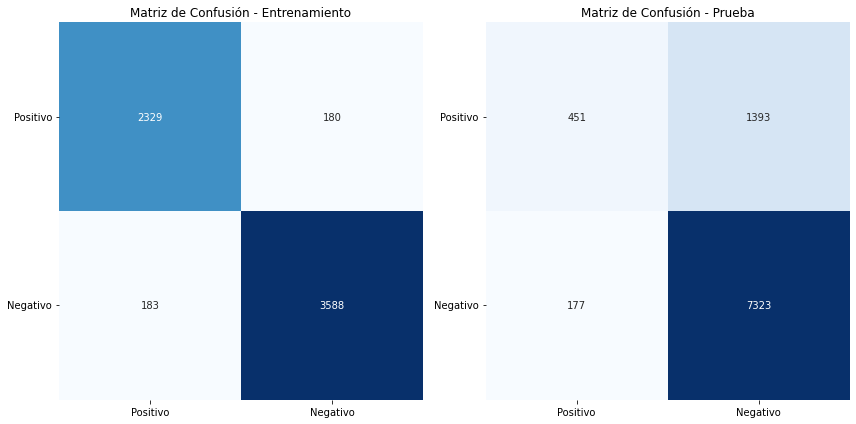

In [37]:
MatrizConfusion(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba)

In [38]:
def Metricas(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba):
    # Calcular métricas para el conjunto de entrenamiento
    precision_entrenamiento = (vp_entrenamiento + vn_entrenamiento) / (vp_entrenamiento + vn_entrenamiento + fp_entrenamiento + fn_entrenamiento)
    sensibilidad_entrenamiento = vp_entrenamiento / (vp_entrenamiento + fn_entrenamiento)
    especificidad_entrenamiento = vn_entrenamiento / (vn_entrenamiento + fp_entrenamiento)
    puntuacion_f1_entrenamiento = 2 * (precision_entrenamiento * sensibilidad_entrenamiento) / (precision_entrenamiento + sensibilidad_entrenamiento)

    # Calcular métricas para el conjunto de prueba
    precision_prueba = (vp_prueba + vn_prueba) / (vp_prueba + vn_prueba + fp_prueba + fn_prueba)
    sensibilidad_prueba = vp_prueba / (vp_prueba + fn_prueba)
    especificidad_prueba = vn_prueba / (vn_prueba + fp_prueba)
    puntuacion_f1_prueba = 2 * (precision_prueba * sensibilidad_prueba) / (precision_prueba + sensibilidad_prueba)

    # Imprimir métricas
    print("Métricas del conjunto de entrenamiento:")
    print("Precisión (Accuracy):", precision_entrenamiento)
    print("Sensibilidad (Recall):", sensibilidad_entrenamiento)
    print("Especificidad:", especificidad_entrenamiento)
    print("Puntuación F1:", puntuacion_f1_entrenamiento)
    print("\nMétricas del conjunto de prueba:")
    print("Precisión (Accuracy):", precision_prueba)
    print("Sensibilidad (Recall):", sensibilidad_prueba)
    print("Especificidad:", especificidad_prueba)
    print("Puntuación F1:", puntuacion_f1_prueba)

In [39]:
Metricas(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba)

Métricas del conjunto de entrenamiento:
Precisión (Accuracy): 0.9421974522292994
Sensibilidad (Recall): 0.9271496815286624
Especificidad: 0.9522292993630573
Puntuación F1: 0.9346130015085984

Métricas del conjunto de prueba:
Precisión (Accuracy): 0.8319777397260274
Sensibilidad (Recall): 0.7181528662420382
Especificidad: 0.8401789811840293
Puntuación F1: 0.7708862674325235


In [12]:
Confusion = np.copy(np.array(modelo2.confusion(X_train, Y_train)))
print("VP Entrenamiento: ", Confusion[0][0])
print("VN Entrenamiento: ", Confusion[1][1])
print("FP Entrenamiento: ", Confusion[0][1])
print("FN Entrenamiento: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo2.confusion(X_test, Y_test)))
print("VP Prueba: ", Confusion[0][0])
print("VN Prueba: ", Confusion[1][1])
print("FP Prueba: ", Confusion[0][1])
print("FN Prueba: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo2.confusion(X_test_sin, Y_test_sin)))
print("VP Prueba sin extras: ", Confusion[0][0])
print("VN Prueba sin extras: ", Confusion[1][1])
print("FP Prueba sin extras: ", Confusion[0][1])
print("FN Prueba sin extras: ", Confusion[1][0])

print("Matriz de confusión con Adam")

'''
VP Entrenamiento:  1375
VN Entrenamiento:  2088
FP Entrenamiento:  1680
FN Entrenamiento:  1137
VP Prueba:  338
VN Prueba:  22352
FP Prueba:  17460
FN Prueba:  290
VP Prueba sin extras:  338
VN Prueba sin extras:  4854
FP Prueba sin extras:  3862
FN Prueba sin extras:  290
Matriz de confusión con Adam
'''

VP Entrenamiento:  1360
VN Entrenamiento:  2123
FP Entrenamiento:  1645
FN Entrenamiento:  1152
VP Prueba:  353
VN Prueba:  22317
FP Prueba:  17495
FN Prueba:  275
VP Prueba sin extras:  353
VN Prueba sin extras:  4856
FP Prueba sin extras:  3860
FN Prueba sin extras:  275
Matriz de confusión con Adam


'\nVP Entrenamiento:  1375\nVN Entrenamiento:  2088\nFP Entrenamiento:  1680\nFN Entrenamiento:  1137\nVP Prueba:  338\nVN Prueba:  22352\nFP Prueba:  17460\nFN Prueba:  290\nVP Prueba sin extras:  338\nVN Prueba sin extras:  4854\nFP Prueba sin extras:  3862\nFN Prueba sin extras:  290\nMatriz de confusión con Adam\n'

Métricas del conjunto de entrenamiento:
Precisión (Accuracy): 0.5514331210191082
Sensibilidad (Recall): 0.5473726114649682
Especificidad: 0.554140127388535
Puntuación F1: 0.5493953636702222

Métricas del conjunto de prueba:
Precisión (Accuracy): 0.5556506849315068
Sensibilidad (Recall): 0.5382165605095541
Especificidad: 0.5569068379990821
Puntuación F1: 0.5467946896390131


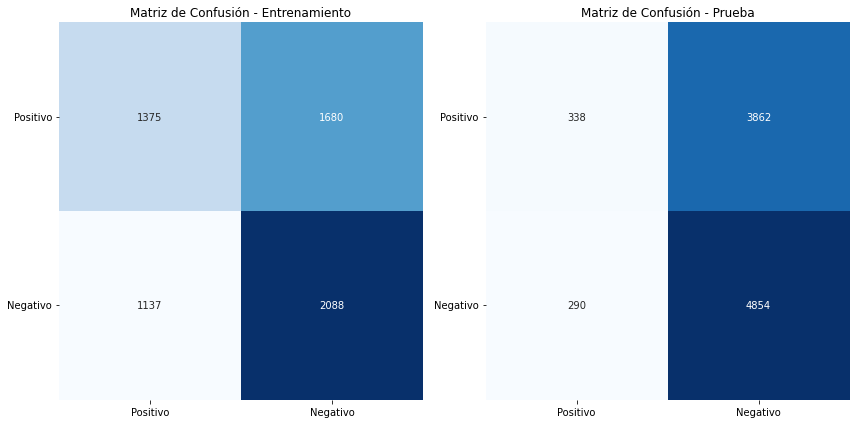

In [40]:
vp_entrenamiento = 1375
vn_entrenamiento = 2088
fp_entrenamiento = 1680
fn_entrenamiento = 1137

vp_prueba = 338
vn_prueba = 4854
fp_prueba = 3862
fn_prueba = 290

Metricas(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba)
MatrizConfusion(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba)

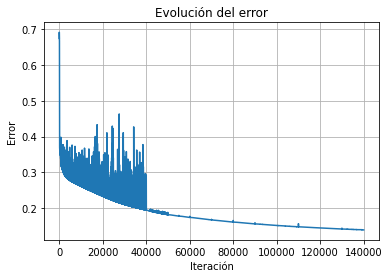

In [45]:
plt.title("Evolución del error")
plt.xlabel("Iteración")
plt.ylabel("Error")
plt.plot(modelo.historial)
plt.grid()
plt.show()

In [14]:
# Leer el archivo CSV
df2 = pd.read_csv('dfCowanDuflo.csv')

df_one_hot2 = OneHot(df2)

X = df_one_hot2.drop('HSV-2 infection', axis=1)
y = df_one_hot2['HSV-2 infection']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]

In [15]:
train_data = pd.concat([X_train, Y_train], axis=1)

clase_positiva = train_data[train_data['HSV-2 infection'] == 1]
clase_negativa = train_data[train_data['HSV-2 infection'] == 0]

n_muestras = int(min(len(clase_positiva)*(6/4), len(clase_negativa)))
clase_positiva_muestreada = resample(clase_positiva, replace=False, n_samples=len(clase_positiva), random_state=42)
clase_negativa_muestreada = resample(clase_negativa, replace=False, n_samples=n_muestras, random_state=42)

train_data_balanceado = pd.concat([clase_positiva_muestreada, clase_negativa_muestreada])

X_train_balanceado = train_data_balanceado.drop('HSV-2 infection', axis=1)
Y_train_balanceado = train_data_balanceado['HSV-2 infection']

indices_no_balanceados = train_data.index.difference(train_data_balanceado.index)

X_test_sin = np.copy(X_test)
Y_test_sin = np.copy(Y_test)
X_test = X_test.append(X_train.loc[indices_no_balanceados])
Y_test = Y_test.append(Y_train.loc[indices_no_balanceados])

X_train = X_train.drop(indices_no_balanceados)
Y_train = Y_train.drop(indices_no_balanceados)

X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()

# Convertir las matrices numpy a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Convertir arrays numpy a tensores PyTorch
X_test_sin = torch.tensor(X_test_sin, dtype=torch.float32)
Y_test_sin = torch.tensor(Y_test_sin, dtype=torch.float32)

# Clonar y desvincular si es necesario (esto es opcional y depende del uso)
X_test_sin = X_test_sin.clone().detach().float()
Y_test_sin = Y_test_sin.clone().detach().float()

In [16]:
Confusion = np.copy(np.array(modelo2.confusion(X_train, Y_train)))
print("VP Entrenamiento: ", Confusion[0][0])
print("VN Entrenamiento: ", Confusion[1][1])
print("FP Entrenamiento: ", Confusion[0][1])
print("FN Entrenamiento: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo2.confusion(X_test, Y_test)))
print("VP Prueba: ", Confusion[0][0])
print("VN Prueba: ", Confusion[1][1])
print("FP Prueba: ", Confusion[0][1])
print("FN Prueba: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo2.confusion(X_test_sin, Y_test_sin)))
print("VP Prueba sin extras: ", Confusion[0][0])
print("VN Prueba sin extras: ", Confusion[1][1])
print("FP Prueba sin extras: ", Confusion[0][1])
print("FN Prueba sin extras: ", Confusion[1][0])

print("Matriz de confusión con Adam")

'''
VP Entrenamiento:  304
VN Entrenamiento:  634
FP Entrenamiento:  65
FN Entrenamiento:  162
VP Prueba:  19
VN Prueba:  3114
FP Prueba:  1200
FN Prueba:  33
VP Prueba sin extras:  19
VN Prueba sin extras:  345
FP Prueba sin extras:  157
FN Prueba sin extras:  33
Matriz de confusión con Adam
'''

VP Entrenamiento:  291
VN Entrenamiento:  541
FP Entrenamiento:  158
FN Entrenamiento:  175
VP Prueba:  32
VN Prueba:  3207
FP Prueba:  1107
FN Prueba:  20
VP Prueba sin extras:  32
VN Prueba sin extras:  380
FP Prueba sin extras:  122
FN Prueba sin extras:  20
Matriz de confusión con Adam


'\nVP Entrenamiento:  304\nVN Entrenamiento:  634\nFP Entrenamiento:  65\nFN Entrenamiento:  162\nVP Prueba:  19\nVN Prueba:  3114\nFP Prueba:  1200\nFN Prueba:  33\nVP Prueba sin extras:  19\nVN Prueba sin extras:  345\nFP Prueba sin extras:  157\nFN Prueba sin extras:  33\nMatriz de confusión con Adam\n'

Métricas del conjunto de entrenamiento:
Precisión (Accuracy): 0.8051502145922746
Sensibilidad (Recall): 0.6523605150214592
Especificidad: 0.9070100143061517
Puntuación F1: 0.7207469529919066

Métricas del conjunto de prueba:
Precisión (Accuracy): 0.6570397111913358
Sensibilidad (Recall): 0.36538461538461536
Especificidad: 0.6872509960159362
Puntuación F1: 0.46961363482039786


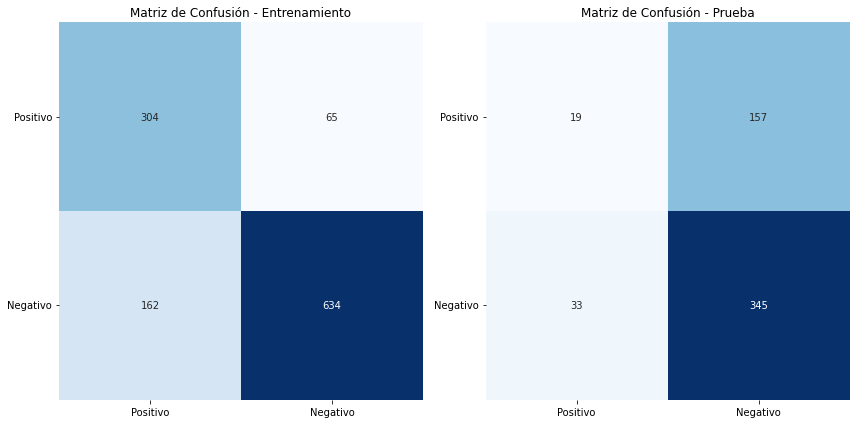

In [43]:
vp_entrenamiento = 304
vn_entrenamiento = 634
fp_entrenamiento = 65
fn_entrenamiento = 162

vp_prueba = 19
vn_prueba = 345
fp_prueba = 157
fn_prueba = 33

Metricas(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba)
MatrizConfusion(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba)

In [17]:
Confusion = np.copy(np.array(modelo.confusion(X_train, Y_train)))
print("VP Entrenamiento: ", Confusion[0][0])
print("VN Entrenamiento: ", Confusion[1][1])
print("FP Entrenamiento: ", Confusion[0][1])
print("FN Entrenamiento: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo.confusion(X_test, Y_test)))
print("VP Prueba: ", Confusion[0][0])
print("VN Prueba: ", Confusion[1][1])
print("FP Prueba: ", Confusion[0][1])
print("FN Prueba: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo.confusion(X_test_sin, Y_test_sin)))
print("VP Prueba sin extras: ", Confusion[0][0])
print("VN Prueba sin extras: ", Confusion[1][1])
print("FP Prueba sin extras: ", Confusion[0][1])
print("FN Prueba sin extras: ", Confusion[1][0])

print("Matriz de confusión con Adam")

'''
VP Entrenamiento:  213
VN Entrenamiento:  490
FP Entrenamiento:  209
FN Entrenamiento:  253
VP Prueba:  21
VN Prueba:  2992
FP Prueba:  1322
FN Prueba:  31
VP Prueba sin extras:  21
VN Prueba sin extras:  340
FP Prueba sin extras:  162
FN Prueba sin extras:  31
Matriz de confusión con Adam
'''

VP Entrenamiento:  205
VN Entrenamiento:  478
FP Entrenamiento:  221
FN Entrenamiento:  261
VP Prueba:  29
VN Prueba:  3004
FP Prueba:  1310
FN Prueba:  23
VP Prueba sin extras:  29
VN Prueba sin extras:  352
FP Prueba sin extras:  150
FN Prueba sin extras:  23
Matriz de confusión con Adam


'\nVP Entrenamiento:  213\nVN Entrenamiento:  490\nFP Entrenamiento:  209\nFN Entrenamiento:  253\nVP Prueba:  21\nVN Prueba:  2992\nFP Prueba:  1322\nFN Prueba:  31\nVP Prueba sin extras:  21\nVN Prueba sin extras:  340\nFP Prueba sin extras:  162\nFN Prueba sin extras:  31\nMatriz de confusión con Adam\n'

Métricas del conjunto de entrenamiento:
Precisión (Accuracy): 0.6034334763948498
Sensibilidad (Recall): 0.4570815450643777
Especificidad: 0.7010014306151645
Puntuación F1: 0.5201591682399961

Métricas del conjunto de prueba:
Precisión (Accuracy): 0.6516245487364621
Sensibilidad (Recall): 0.40384615384615385
Especificidad: 0.6772908366533864
Puntuación F1: 0.4986515819246202


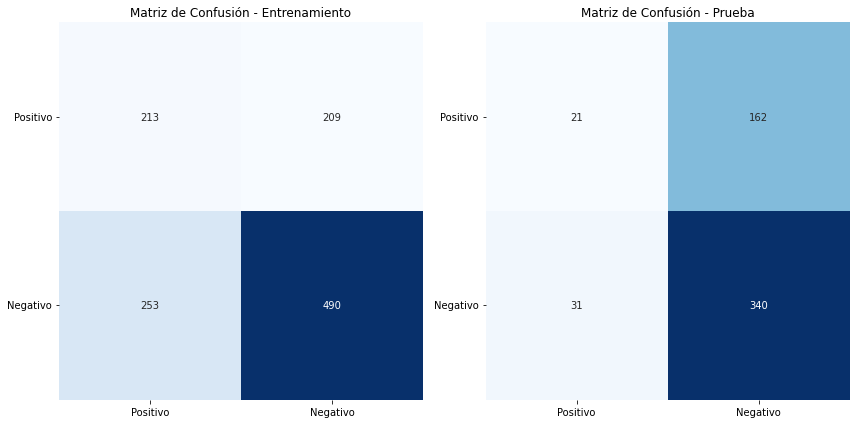

In [44]:
vp_entrenamiento = 213
vn_entrenamiento = 490
fp_entrenamiento = 209
fn_entrenamiento = 253

vp_prueba = 21
vn_prueba = 340
fp_prueba = 162
fn_prueba = 31

Metricas(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba)
MatrizConfusion(vp_entrenamiento, vn_entrenamiento, fp_entrenamiento, fn_entrenamiento, vp_prueba, vn_prueba, fp_prueba, fn_prueba)

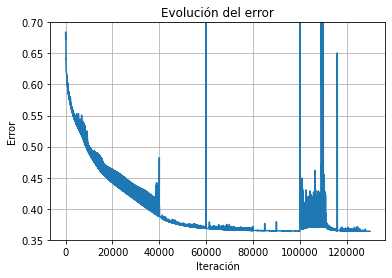

In [53]:
plt.title("Evolución del error")
plt.xlabel("Iteración")
plt.ylabel("Error")
plt.plot(modelo2.historial[:130000])
plt.ylim(0.35,0.7)
plt.grid()
plt.show()